In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

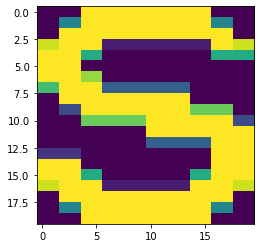

In [2]:
arial = pd.read_csv('/Users/derekolson/DerekOlson/CS6017/homework6/fonts/Arial.csv')
df = arial.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d = df.loc[:, df.columns != 'm_label']
reshaped = d.to_numpy().reshape(-1,20,20)
plt.imshow(reshaped[2,:,:])

In [3]:
reshaped = reshaped.astype('float64')
reshaped *= (1.0/reshaped.max())
y = df.loc[:, df.columns == 'm_label'].to_numpy()
y_unq = np.unique(y)

In [4]:
labels = {}
for i in range(len(y_unq)):
    labels[i] = y_unq[i]

In [5]:
def get_key(val, d): 
    for key, value in d.items(): 
         if val == value: 
             return key 
         
y_labels = []            
for i in range(0, len(y), 1):
    y_labels.append(get_key(y[i], labels))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(reshaped, y_labels, random_state=1, test_size=0.3)    

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        c1Out = 32 # convoluation layer 1 will output 6 "images": one for each filter it trains
        c2Out = 32 # similarly for the 2nd convolution layer
        self.conv1 = nn.Conv2d(1, c1Out, 5) #1-D input, c1Out outputs, filter size 3x3 pixels
        
        # (28-2)*(28 -2)*c1Out outputs
        
        self.pool = nn.MaxPool2d(2, 2) #downsample 2x2 blocks to 1 value
        
        # 13*13*c1Out
        
        self.conv2 = nn.Conv2d(c1Out, c2Out, 5) #inputs comes from conv1 , specify our #outputs, use 3x3 blocks again
        
        # (8-4)*(8-4)*c2Out
        # pool again
        # (11/2)*(11/2)*c2Out = 5*5*c2Out
        
        #this is tricky.  The convolutions each shave 1 pixel off around the border, and then the
        #max pools reduce the number of pixels by 4
        self.pooledOutputSize = c2Out*2*2 # 16 outputs per image whose size has been reduced
        self.fc1 = nn.Linear(self.pooledOutputSize, 3200)
        self.fc2 = nn.Linear(3200, len(y_unq))
        #self.fc3 = nn.Linear(84, 10)


    def forward(self, x): # "batch" of images
        #x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))
        #after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        #after max pool: (batch size, width/2, height/2, conv1 # outputs)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        #x = self.pool(F.relu(self.conv2(x))) #ditto
        #print(x.shape) #uncomment to see the size of this layer.  It helped me figure out what pooledOutputSize shoudl be

        #turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        # x.view(batch_size( x.shape[0]) , -1)
        x = F.relu(self.fc1(x)) #apply dense layer 1
        #x = F.relu(self.fc2(x)) #and dense layer 2, using ReLU activation
        x = self.fc2(x) #final dense layer.  No activation function on this
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

In [8]:
xy_train = []
for i in range(0, len(X_train), 1):
    xy_train.append((X_train[i], y_train[i]))
    
xy_test = []
for i in range(0, len(X_test), 1):
    xy_test.append((X_test[i], y_test[i]))

In [9]:
def train(model, epochs, data):
    criterion = nn.CrossEntropyLoss() #this is a way of measuring error for classification that takes the
    #"confidence" of a prediction into account.  High confidence, correct predictions are low cost, 
    #high confidence, wrong predictions are high cost, medium confidence predictions have cost

    #use the ADAM optimizer to find the best weights
    optimizer = optim.Adam(model.parameters(), lr= 1e-4) 
    
    #this loads data and gets it in the right format for us
    trainloader = torch.utils.data.DataLoader(data, batch_size=8,
                                              shuffle=True, num_workers=0)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]

            inputs, labels = data
            inputs = inputs.reshape((-1,1,20,20))
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float()) #predict the output with some training data
            loss = criterion(outputs, labels) #see how well we did
            loss.backward() #see how to change the weights to do better
            optimizer.step() #and actually change the weights

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

In [10]:
def evaluate(model, data):  
    #load some test data
    testloader = torch.utils.data.DataLoader(data, batch_size=8,
                                                shuffle=True, num_workers=0)
    correct = 0
    total = 0
    to_return = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.reshape((-1,1,20,20))
            outputs = model(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            bools = predicted == labels
            for i in range(len(bools)):
                if bools[i] == False:
                    to_return.append(predicted[i].item())

    #just do a coarse evaluation... how many did we predict correcly?
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    return to_return

In [11]:
train(net, 4, xy_train)

[1,  2000] loss: 5.286
[2,  2000] loss: 2.663
[3,  2000] loss: 1.575
[4,  2000] loss: 1.171
Finished Training


In [12]:
out = evaluate(net, xy_test)

Accuracy of the network on the test images: 55 %


In [13]:
#The accuracy is 55%

In [14]:
times = pd.read_csv('/Users/derekolson/DerekOlson/CS6017/homework6/fonts/TIMES.csv')

In [15]:
df_times = times.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d_times = df_times.loc[:, df_times.columns != 'm_label']
reshaped_times = d_times.to_numpy().reshape(-1,20,20)

In [16]:
reshaped_times = reshaped_times.astype('float64')
reshaped_times *= (1.0/reshaped_times.max())

y_times = df_times.loc[:, df_times.columns == 'm_label'].to_numpy()

y_unq_times = np.unique(y_times)

In [17]:
labels_times = {}
for i in range(len(y_unq_times)):
    labels_times[i] = y_unq_times[i]

In [18]:
y_labels_times = []            
for i in range(0, len(y_times), 1):
    y_labels_times.append(get_key(y_times[i], labels_times))

In [19]:
X_train_times, X_test_times, y_train_times, y_test_times = train_test_split(reshaped_times, y_labels_times, random_state=1, test_size=0.3)  

In [20]:
xy_train_times = []
for i in range(0, len(X_train_times), 1):
    xy_train_times.append((X_train_times[i], y_train_times[i]))
    
xy_test_times = []
for i in range(0, len(X_test_times), 1):
    xy_test_times.append((X_test_times[i], y_test_times[i]))

In [21]:
train(net, 4, xy_train_times)

Finished Training


In [22]:
eval_times = evaluate(net, xy_test_times)

Accuracy of the network on the test images: 25 %


In [23]:
#Times performs much worse than arial

In [24]:
two_fonts = pd.concat([arial, times], axis=0)

In [25]:
df2 = two_fonts.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d2 = df2.loc[:, df2.columns != 'm_label']
reshaped2 = d2.to_numpy().reshape(-1,20,20)

In [26]:
reshaped2 = reshaped2.astype('float64')
reshaped2 *= (1.0/reshaped2.max())

y2 = df2.loc[:, df2.columns == 'm_label'].to_numpy()

y_unq2 = np.unique(y2)

In [27]:
labels2 = {}
for i in range(len(y_unq2)):
    labels2[i] = y_unq2[i]

In [28]:
y_labels2 = []            
for i in range(0, len(y2), 1):
    y_labels2.append(get_key(y2[i], labels2))

In [29]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(reshaped2, y_labels2, random_state=1, test_size=0.3)  

In [30]:
xy_train2 = []
for i in range(0, len(X_train2), 1):
    xy_train2.append((X_train2[i], y_train2[i]))
    
xy_test2 = []
for i in range(0, len(X_test2), 1):
    xy_test2.append((X_test2[i], y_test2[i]))

In [31]:
train(net, 4, xy_train2)

[1,  2000] loss: 2.856
[2,  2000] loss: 1.671
[3,  2000] loss: 1.276
[4,  2000] loss: 1.062
Finished Training


In [32]:
eval_twoFonts = evaluate(net, xy_test2)

Accuracy of the network on the test images: 54 %


In [33]:
#The performance was about as good as arial alone

In [34]:
lucida = pd.read_csv('/Users/derekolson/DerekOlson/CS6017/homework6/fonts/LUCIDA.csv')

In [35]:
df_lucida = lucida.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d_lucida = df_lucida.loc[:, df_lucida.columns != 'm_label']
reshaped_lucida = d_lucida.to_numpy().reshape(-1,20,20)

In [36]:
reshaped_lucida = reshaped_lucida.astype('float64')
reshaped_lucida *= (1.0/reshaped_lucida.max())

y_lucida = df_lucida.loc[:, df_lucida.columns == 'm_label'].to_numpy()

y_unq_lucida = np.unique(y_lucida)

In [37]:
labels_lucida = {}
for i in range(len(y_unq_lucida)):
    labels_lucida[i] = y_unq_lucida[i]

In [38]:
y_labels_lucida = []            
for i in range(0, len(y_lucida), 1):
    y_labels_lucida.append(get_key(y_lucida[i], labels_lucida))

In [39]:
X_train_lucida, X_test_lucida, y_train_lucida, y_test_lucida = train_test_split(reshaped_lucida, y_labels_lucida, random_state=1, test_size=0.3)  

In [40]:
xy_test_lucida = []
for i in range(0, len(X_test_lucida), 1):
    xy_test_lucida.append((X_test_lucida[i], y_test_lucida[i]))

In [41]:
eval_lucida = evaluate(net, xy_test_lucida)

Accuracy of the network on the test images: 20 %


In [42]:
#The accuracy dropped substantially when evaluating a font that the model was not trained on

In [43]:
actual_predicted = []            
for i in range(0, len(out), 1):
    actual_predicted.append(get_key(out[i], labels)) 

In [44]:
def get_value(k, d):
    for key, value in d.items(): 
         if k == key: 
             return value 

In [45]:
def get_counts(data):
    out_dict = {}
    for item in data:
        if item not in out_dict:
            out_dict[item] = 1
        else:
            out_dict[item] += 1
    return out_dict

In [46]:
vals = []
for i in range(len(actual_predicted)):
    vals.append(get_value(out[i], labels))

In [47]:
d = get_counts(vals)

In [48]:
s = sorted(d.items(), key=lambda x:x[1], reverse=True)
print(s)

[(8212, 113), (48, 71), (729, 46), (218, 29), (197, 26), (86, 26), (73, 22), (202, 21), (1040, 19), (732, 17), (7888, 17), (110, 17), (1085, 16), (103, 16), (80, 15), (101, 15), (58, 15), (211, 15), (76, 15), (117, 15), (51, 15), (74, 14), (97, 14), (283, 14), (112, 14), (8217, 14), (96, 14), (925, 13), (33, 13), (88, 13), (412, 13), (364, 13), (84, 13), (203, 12), (1074, 12), (87, 12), (115, 12), (85, 12), (176, 12), (121, 12), (7808, 12), (83, 11), (268, 11), (226, 11), (1112, 11), (90, 11), (596, 11), (304, 11), (8725, 11), (79, 11), (728, 10), (224, 10), (49, 10), (207, 10), (924, 10), (1089, 9), (89, 9), (1042, 9), (56, 9), (180, 9), (57, 9), (1093, 9), (913, 9), (250, 9), (710, 9), (242, 9), (50, 9), (7504, 9), (119, 9), (209, 9), (106, 8), (253, 8), (206, 8), (7678, 8), (8101, 8), (917, 8), (933, 8), (1105, 8), (188, 8), (66, 8), (179, 8), (374, 8), (359, 8), (237, 8), (249, 8), (733, 8), (7923, 8), (337, 8), (1039, 7), (7922, 7), (105, 7), (1078, 7), (116, 7), (333, 7), (1048, 

In [49]:
#Em Dash is my most misclassified with 465 missclassifications

In [50]:
to_noise = pd.read_csv('/Users/derekolson/DerekOlson/CS6017/homework6/fonts/Arial.csv')
df_noise = to_noise.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d_noise = df_noise.loc[:, df_noise.columns != 'm_label']
reshaped_noise = d_noise.to_numpy().reshape(-1,20,20)

In [51]:
reshaped_noise = reshaped_noise.astype('float64')
reshaped_noise *= (1.0/reshaped_noise.max())
y_noise = df_noise.loc[:, df_noise.columns == 'm_label'].to_numpy()
y_unq_noise = np.unique(y_noise)

In [52]:
for image in reshaped_noise:
    noise = np.random.normal(loc=0, scale=.25, size=image.shape)
    image += noise
    image /= np.max(image)

In [53]:
labels_noise = {}
for i in range(len(y_unq_noise)):
    labels_noise[i] = y_unq_noise[i]

In [54]:
y_labels_noise = []            
for i in range(0, len(y), 1):
    y_labels_noise.append(get_key(y_noise[i], labels_noise))

In [55]:
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(reshaped_noise, y_labels_noise, random_state=1, test_size=0.3) 

In [56]:
xy_train_noise = []
for i in range(0, len(X_train_noise), 1):
    xy_train_noise.append((X_train_noise[i], y_train_noise[i]))
    
xy_test_noise = []
for i in range(0, len(X_test_noise), 1):
    xy_test_noise.append((X_test_noise[i], y_test_noise[i]))

In [57]:
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        
        self.encodedSize = 32
        
        self.c1Out = 8 # filters from first conv layer
        self.c2Out = 8 # filters from 2nd conv layer
        
        #the padding here puts a "border" of 0s around the image, so that convolution layers don't "shrink" the image
        
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1) #stick with 3x3 filters
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        #reuse pool here
        
        self.downscaledSize = 20//4 #we add padding, so the conv2d layers don't change the size, just the max pools
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize) #scale down to 64 features

        #now we're encoded, so go define decoding pieces
        
        self.fc3 = nn.Linear(self.encodedSize, 64) #scale down to 64 features
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        # the padding is very important here so we don't have to guess a "frame" of pixels around the image
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        # apply upsample again
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)
        
        
    def compress(self, x):
        x = self.cv1(x)
        #print("shape after cv1", x.shape)
        x = F.relu(self.pool(x))
        #print("shape after pool1", x.shape)
        x = self.cv2(x)
        #print("after cv2", x.shape)
        x = F.relu(self.pool(x))
        #print("after pool 2", x.shape)
        x = x.view(-1, self.flattenedSize)
        #print("flattened shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #now we have a low-d representation of our data.  If we were doing compression, we'd store this
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #print(x.shape)
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        #print("unflattened shape", x.shape)
        x = self.upsample(x)
        #print("upsample", x.shape)
        x = F.relu(self.cv3(x))
        #print(x.shape, "after cv3")
        x = self.cv4(self.upsample(x))
        #print(x.shape, "after both upsamples")
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x

cnnNet = CnnNet() # treat these as just 28 D vectors

In [58]:
criterion = nn.MSELoss()
def trainCNN(model, epochs):
    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    
    
    train_loader = torch.utils.data.DataLoader(xy_train_noise, batch_size=8, shuffle=True, num_workers=0)
    
    for epoch in range(epochs):
        loss = 0
        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):

            #same as yesterday, except we're not even looking at the labels!
            # since we're not using a CNN, we need to "flatten" the input images
            batch_features = data[0]
            batch_features = batch_features.reshape(-1,1,20,20)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
        
            # compute reconstructions
            outputs = model(batch_features.float())
            #print(batch_features.shape)
            #print(outputs.shape)
            # compute training reconstruction loss
            # again, same idea as yesterday, but we're measuring the error slightly differently
            # how well does the reconstructed image match the input image?
            train_loss = criterion(outputs, batch_features.float())
        
            # compute accumulated gradients
            train_loss.backward()
        
            # perform parameter update based on current gradients
            optimizer.step()
        
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
    
            # print statistics
            running_loss += train_loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    
        # compute the epoch training loss
        loss = loss / len(train_loader)
    
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

def evaluateCNN(model):
    test_loader = torch.utils.data.DataLoader(xy_test_noise, batch_size=8, shuffle=True, num_workers=0)
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0]
            images = images.reshape(-1,1,20,20)
            outputs = model(images.float())
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print("overall loss: ", total_loss)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


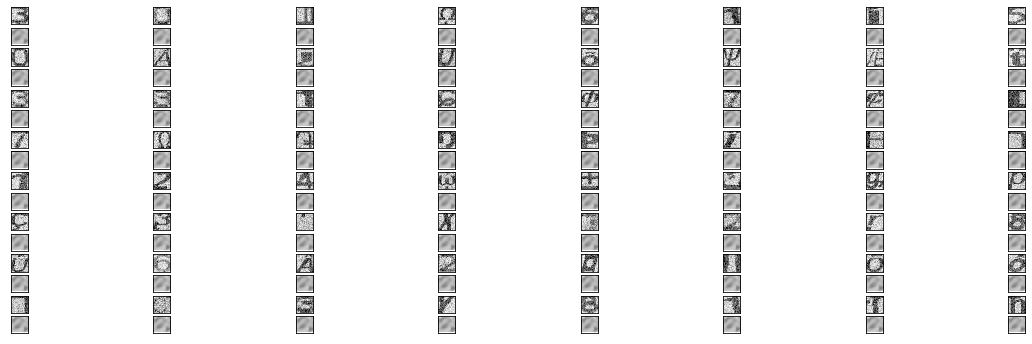

In [59]:
def drawComparisonsCNN(model):
    test_loader = torch.utils.data.DataLoader(xy_test_noise, batch_size=8, shuffle=True, num_workers=0)
    plt.figure(figsize=(20, 6))
    for i, batch in enumerate(test_loader):
        if i >= 8: break
        images = batch[0]
        images = images.reshape(-1,1,20,20)
        #print(images.shape)
        with torch.no_grad():
            reconstructed = model(images.float())
            for j in range(len(images)):
                #draw the original image
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                #and the reconstructed version in the next row
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
drawComparisonsCNN(cnnNet)